In [ ]:
"""
市场设定：

假设市场中共有9位异置投资者：
1. 风险偏好设定：风险爱好、风险中性、风险厌恶者各有三位； 
2. 财富水平设定：两位投资者将在市场中投入一千万元，三位投资者将在市场中投入一百万元，四位投资者将在市场中投入一万元；
3. 信息获取能力：投入十万元的投资者均为机构投资者，投入一万元的投资者有一位为机构投资者，机构拥有更高的信息获取能力，其余均为散户投资者，信息获取能力较低。

具体信息如下：

    风险偏好  财富水平 信息获取
1号   厌恶     1000万      高
2号   中性     1000万      高
3号   厌恶     100万       高
4号   爱好     100万       低
5号   中性     100万       低
6号   厌恶     10万        低
7号   中性     10万        低
8号   爱好     10万        低
9号   爱好     10万        低

不同禀赋投资者策略设定如下：
1. 风险爱好者买入50%高风险股票，30%中风险股票，20%低风险股票；风险中性者买入20%高风险股票，60%中风险股票，20%低风险股票；风险厌恶者买入20%高风险股票，30%中风险股票，50%低风险股票；
2. 信息获取能力强的投资者倾向长期持有股票，在每月第一个交易日买入股票，最后一个交易日卖出；信息获取能力弱的投资者倾向短期持有股票，每两天完成一次股票的买入和卖出（第一天买入，第二天卖出，第三天买入，第四天卖出......）。

假设市场仅有三支股票：万科A（000002）、格力电器（000651）、恒瑞医药（600276）

"""

In [1]:
import numpy as np
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# 获取市场数据

# 定义tushare调取数据函数
def fetch_stock_data(stock_code, stock_name, start, end):
    df = ts.get_hist_data(stock_code, start = start, end = end) 
    df = df.close
    df.name = stock_name
    return df

# 获取三支股票收盘价格
data = pd.DataFrame({'万科A': fetch_stock_data('000002', '万科A', '2022-01-01', '2022-12-31'),
                     '格力电器': fetch_stock_data('000651', '格力电器', '2022-01-01', '2022-12-31'),
                     '恒瑞医药': fetch_stock_data('600276', '恒瑞医药', '2022-01-01', '2023-12-31')})
data = data.dropna()

# 计算股票收益率
returns = np.log(data.pct_change()+1).dropna()

# 测算三支股票风险
cov_matrix = np.cov(returns)
risk002 = cov_matrix[0, 0]
risk651 = cov_matrix[1, 1]
risk276 = cov_matrix[2, 2]
print(risk002, risk651, risk276)

# 股票风险排序：万科A > 恒瑞医药 > 格力电器

NameError: name 'pd' is not defined

In [3]:
# 存储投资者数据

"""
参数设定：
risk: 风险厌恶者为0，风险中性者为0.5，风险偏好这为0；
information: 获取信息能力强为1，获取信息能力弱为0。
"""
investor = pd.DataFrame({'risk': [0, 0.5, 0, 1, 0.5, 0, 0.5, 1, 1],
                         'wealth': [10000000, 10000000, 1000000, 1000000, 1000000, 100000, 100000, 100000, 100000],
                         'information': [1, 1, 1, 0, 0, 0, 0, 0, 0]})
investor

,risk,wealth,information
0,0.0,10000000,1
1,0.5,10000000,1
2,0.0,1000000,1
3,1.0,1000000,0
4,0.5,1000000,0
5,0.0,100000,0
6,0.5,100000,0
7,1.0,100000,0
8,1.0,100000,0


In [4]:
# 交易策略

def strategy(risk: int, wealth: int, information: int) -> int:
    
    # 新建一个DataFrame,以data的index为index
    signal = pd.DataFrame(index=data.index)
    signal[['high_risk', 'median_risk', 'low_risk']] = data[['万科A', '恒瑞医药', '格力电器']]

    # 将索引日期变为列
    signal = signal.reset_index().rename(columns={"date": "date"})
    # 创建空列表month
    month = []
    for i in range(len(signal)):
        # 提取日期中的月份
        month.append(signal['date'][i].split('-')[1])
    # 创建月份列
    signal['month'] = month
    
    # 初始化订单状态为0
    signal['orders'] = 0
    # 初始仓位为0
    position = 0
    
    # 投资者获取信息能力弱
    if information == 0:
        # 设初始买入信号为TRUE，卖出信号为FALSE
        signal['buy_signal'] = 'TRUE'
        signal['sell_signal'] = 'FALSE'
        # 奇数行对应买入信号，偶数行对应卖出信号
        for i in range(1, len(signal)):
            if signal['buy_signal'][i] == signal['buy_signal'][i-1]:
                signal['buy_signal'][i] = "FALSE"
        for i in range(len(signal)-1):
            if signal['sell_signal'][i] == signal['sell_signal'][i+1]:
                signal['sell_signal'][i+1] = "TRUE"
    
    # 投资者获取信息能力强
    elif information == 1:
        # 初始买卖信号均为0
        signal['buy_signal'] = 'FALSE'
        signal['sell_signal'] = 'FALSE'
        # 每个月第一天对应买入信号，每个月最后一天对应卖出信号
        for i in range(1, len(signal)):
            if signal['month'][i] != signal['month'][i-1]:
                signal['buy_signal'][i] = 'TRUE'
        for i in range(len(signal)-1):
            if signal['month'][i] != signal['month'][i+1]:
                signal['sell_signal'][i] = 'TRUE'
        signal['buy_signal'][0] = 'TRUE'
        signal['sell_signal'][len(signal)-1] = 'TRUE'
        
        
    # 遍历数据表
    for i in range(len(signal)):
        # 当买入信号为True且仓位为0时买入
        if signal.buy_signal[i] == 'TRUE' and position == 0:
            # 买入指令为1
            signal.orders.values[i] = 1
            # 仓位加1
            position = 1

        # 当卖出信号为True且仓位为1时卖出
        elif signal.sell_signal[i] == 'TRUE' and position == 1:
            # 卖出指令为-1
            signal.orders.values[i] = -1
            # 仓位清0
            position = 0
    
    # 初始各个股票最大可持仓量为0，交易金额为0，可用资金为wealth
    position_high = 0
    position_median = 0
    position_low = 0
    trade_high = 0
    trade_median = 0
    trade_low = 0
    money = wealth
    
    # 初始持仓股票手数、可用资金、交易资金
    signal['stock_high'] = 0
    signal['stock_median'] = 0
    signal['stock_low'] = 0
    signal['money'] = wealth   
            
    for i in range(len(signal)):
        # 当买卖指令为1时
        if signal.orders.values[i] == 1:
            # 风险厌恶者：20%high_risk，30%median_risk，50%low_risk
            if risk == 0:
                position_high = money * 0.2 // (signal.high_risk.values[i] * 100)
                position_median = money * 0.3 // (signal.median_risk.values[i] * 100)
                position_low = money * 0.5 // (signal.low_risk.values[i] * 100)
                trade_high =  - signal.high_risk.values[i] * 100
                trade_median =  - signal.median_risk.values[i] * 100
                trade_low =  - signal.low_risk.values[i] * 100
                money = money + position_high * trade_high + position_median * trade_median + position_low * trade_low
            # 风险中立者：20%high_risk，60%median_risk，20%low_risk
            if risk == 0.5:
                position_high = money * 0.2 // (signal.high_risk.values[i] * 100)
                position_median = money * 0.6 // (signal.median_risk.values[i] * 100)
                position_low = money * 0.2 // (signal.low_risk.values[i] * 100)
                trade_high =  - signal.high_risk.values[i] * 100
                trade_median =  - signal.median_risk.values[i] * 100
                trade_low =  - signal.low_risk.values[i] * 100
                money = money + position_high * trade_high + position_median * trade_median + position_low * trade_low
            # 风险偏好者：50%high_risk，30%median_risk，20%low_risk
            if risk == 1:
                position_high = money * 0.5 // (signal.high_risk.values[i] * 100)
                position_median = money * 0.3 // (signal.median_risk.values[i] * 100)
                position_low = money * 0.2 // (signal.low_risk.values[i] * 100)
                trade_high =  - signal.high_risk.values[i] * 100
                trade_median =  - signal.median_risk.values[i] * 100
                trade_low =  - signal.low_risk.values[i] * 100
                money = money + position_high * trade_high + position_median * trade_median + position_low * trade_low        
        # 当买卖指令为-1时
        elif signal.orders.values[i] == -1:
            money = money + position_high * signal.high_risk.values[i] + position_median * signal.median_risk.values[i] + position_low * signal.low_risk.values[i]
            position_high = 0
            position_median = 0
            position_low = 0
            
        # 持仓数、可用资金
        signal['stock_high'].values[i] = position_high
        signal['stock_median'].values[i] = position_median
        signal['stock_low'].values[i] = position_low
        signal['money'].values[i] = money
 
    # 账户资产总额
    signal['total'] = (signal['stock_high'] * signal['high_risk'] + signal['stock_median'] * signal['median_risk'] + signal['stock_low'] * signal['low_risk']) * 100 + signal['money']
 
    return signal

In [5]:
# 测试策略

test_strategy = strategy(investor['risk'][0], investor['wealth'][0], investor['information'][0])
test_strategy

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20552/1422819951.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['buy_signal'][i] = 'TRUE'
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20552/1422819951.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['sell_signal'][i] = 'TRUE'
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20552/1422819951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['buy_signal'][

,date,high_risk,median_risk,low_risk,month,orders,buy_signal,sell_signal,stock_high,stock_median,stock_low,money,total
0,2022-01-04,20.49,50.39,37.58,01,1,TRUE,FALSE,976,595,1330,3831,10000000.0
1,2022-01-05,21.17,50.92,39.05,01,0,FALSE,FALSE,976,595,1330,3831,10293413.0
2,2022-01-06,21.05,50.11,38.61,01,0,FALSE,FALSE,976,595,1330,3831,10174986.0
3,2022-01-07,21.89,50.88,40.14,01,0,FALSE,FALSE,976,595,1330,3831,10506275.0
4,2022-01-10,22.16,51.12,40.27,01,0,FALSE,FALSE,976,595,1330,3831,10564197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-12-26,18.37,37.56,32.35,12,0,FALSE,FALSE,0,0,0,5765,5765.0
238,2022-12-27,18.51,37.07,32.63,12,0,FALSE,FALSE,0,0,0,5765,5765.0
239,2022-12-28,18.58,37.40,32.57,12,0,FALSE,FALSE,0,0,0,5765,5765.0
240,2022-12-29,18.16,38.13,32.16,12,0,FALSE,FALSE,0,0,0,5765,5765.0


In [6]:
# 每月月末各投资者财富总量

Jan = []
Feb = []
Mar = []
Apr = []
May = []
Jun = []
Jul = []
Aug = []
Sep = []
Oct = []
Nov = []
Dec = []

for i in range(len(investor)):
    wealth_sum = strategy(investor['risk'][i], investor['wealth'][i], investor['information'][i])
    for j in range(len(wealth_sum)):
        if wealth_sum['month'][j] == '01' and wealth_sum['month'][j+1] == '02':
            Jan.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '02' and wealth_sum['month'][j+1] == '03':
            Feb.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '03' and wealth_sum['month'][j+1] == '04':
            Mar.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '04' and wealth_sum['month'][j+1] == '05':
            Apr.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '05' and wealth_sum['month'][j+1] == '06':
            May.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '06' and wealth_sum['month'][j+1] == '07':
            Jun.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '07' and wealth_sum['month'][j+1] == '08':
            Jul.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '08' and wealth_sum['month'][j+1] == '09':
            Aug.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '09' and wealth_sum['month'][j+1] == '10':
            Sep.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '10' and wealth_sum['month'][j+1] == '11':
            Oct.append(wealth_sum['total'].tolist()[j])
        elif wealth_sum['month'][j] == '11' and wealth_sum['month'][j+1] == '12':
            Nov.append(wealth_sum['total'].tolist()[j])
        Dec.append(wealth_sum['total'].tolist()[len(wealth_sum)-1])

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20552/1422819951.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['buy_signal'][i] = 'TRUE'
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20552/1422819951.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['sell_signal'][i] = 'TRUE'
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20552/1422819951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['buy_signal'][

In [7]:
# 测算基尼系数

def gini_index(wealth_list: list[float]) -> float:

    arr = sorted(wealth_list)
    length = len(arr)
    div = 2 * length * sum(arr)
    
    total = 0
    for i in range(length):
        for j in range(length):
            total += abs(arr[i] - arr[j])
            
    return total / div

gini = [gini_index(Jan), gini_index(Feb), gini_index(Mar), gini_index(Apr), gini_index(May), gini_index(Jun), gini_index(Jul), gini_index(Aug), gini_index(Sep), gini_index(Oct), gini_index(Nov), gini_index(Dec)]
gini

[0.6526344707614857,
 0.19846520757060748,
 0.22917231068701524,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558,
 0.23532202761560558]

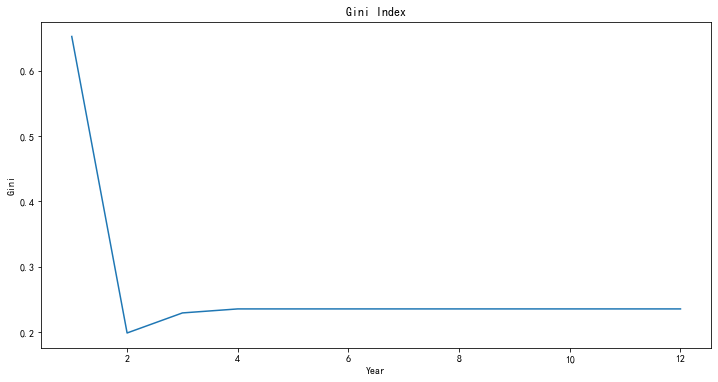

In [8]:
# 绘制每年基尼系数折线图

#设置画布大小
plt.figure(figsize=(12, 6))

# 正确显示中文和负号
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 画图，plt.bar()可以画柱状图
plt.plot(np.arange(1, 13).tolist(), gini)

# 设置图表名称
plt.title("Gini Index")
# 设置x轴标签名
plt.xlabel("Year")
# 设置y轴标签名
plt.ylabel("Gini")
# 显示
plt.show()